# Hierarchical clustering
In exp. 19, we have noted that Tangles seems to work well on data that has a kind of "hierarchical" cluster structure, and even requires that. We want to investigate this further.

## Totally unhierarchical data
We picture an extreme case: Assuming that there are $k$ clusters with labels $1\ldots k$. 
Let $L(x)$ denote the cluster that a point $x$ belongs to.

The data is completely unhierarchical, when for a triplet $(a,b,c)$

$$ 
(a,b,c) = 
\begin{cases}
1, & \text{if } L(a) = L(b), \\
0, & \text{if } L(a) = L(c), \\
\text{random} & \text{else}
\end{cases} 
$$

This results in a cut $b:c?$ only being able to separate exactly two clusters, while not giving any information about the rest of the cluster structure.

In [1]:
import sys
sys.path.append("..")
import numpy as np
import cblearn.datasets as datasets
from data_generation import generate_gmm_data_fixed_means
from questionnaire import Questionnaire
from estimators import OrdinalTangles, SoeKmeans
from cblearn.embedding import SOE
from sklearn.metrics import normalized_mutual_info_score
from plotting import AltairPlotter
from copy import deepcopy
from hierarchies import get_primitives, HierarchyNode, HierarchyTree, merge_nodes

In [2]:
seed=1
data = generate_gmm_data_fixed_means(n = 150, means = np.array([[-6, 3], [-6, -3], [6, 3], [6, -3]]), std=1.3, seed=seed)
p = AltairPlotter()
p.assignments(data.xs, data.ys)

alt.Chart(...)

In [3]:
def make_non_hierarchical(q, ys): 
    q_ = deepcopy(q)
    for i in range(len(q.labels)):
        b, c = q.labels[i]
        ys_b = ys[b]
        ys_c = ys[c]
        mask = np.logical_not(np.logical_or(ys == ys_b, ys == ys_c))
        q_.values[mask, i] = np.random.random(size=mask.sum()) > 0.5
    return q_ 

In [4]:
q = Questionnaire.from_metric(data.xs, density=0.001, seed=seed)
print(f"# triplets used: {q.values.size}")

q_non_hierarchial = make_non_hierarchical(q, data.ys)
tangles = OrdinalTangles(agreement=75, verbose=False)
ys_tangles_non_hierarchical = tangles.fit_predict(q_non_hierarchial.values)
print(f"NMI tangles non-hierarchical: {normalized_mutual_info_score(ys_tangles_non_hierarchical, data.ys)} ({np.unique(ys_tangles_non_hierarchical).size})")
ys_tangles_normal = tangles.fit_predict(q.values)
print(f"NMI tangles normal: {normalized_mutual_info_score(ys_tangles_normal, data.ys)} ({np.unique(ys_tangles_normal).size})")

soe_kmeans = SoeKmeans(embedding_dimension=2, n_clusters=4, seed=seed)
ys_kmeans_non_hierarchical = soe_kmeans.fit_predict(*q_non_hierarchial.to_bool_array())
print(f"NMI soe-kmeans non-hierarchical: {normalized_mutual_info_score(ys_kmeans_non_hierarchical, data.ys)}")
ys_kmeans_normal = soe_kmeans.fit_predict(*q.to_bool_array())
print(f"NMI soe-kmeans normal: {normalized_mutual_info_score(ys_kmeans_normal, data.ys)}")


Generating questionnaire...
Generating question set...
Filling out questionnaire...


100%|██████████| 600/600 [00:00<00:00, 11006.12it/s]

# triplets used: 108000


NMI tangles non-hierarchical: 0.33388454142706964 (3)
NMI tangles normal: 0.9600076652836476 (4)
NMI soe-kmeans non-hierarchical: 0.8349888276179522
NMI soe-kmeans normal: 0.9672175510481585


As an aside, notice how much faster the Tangles algorithm is, even without a super-efficient implementation. 

But we can clearly see that removing the hierarchical information poses a much more pronounced problem for Tangles than for SOE-kMeans.

Now we try for a specific hierarchical setup.

In [5]:
primitives = get_primitives([0,1,2,3])
nodes_01 = merge_nodes([primitives[0], primitives[1]])
nodes_23 = merge_nodes([primitives[2], primitives[3]])
tree = HierarchyTree(merge_nodes([nodes_01, nodes_23]))

First we will inspect the data.

In [6]:
def plot_cut(q, col):
    p = AltairPlotter()
    b, c = q.labels[col]
    return p.assignments(data.xs, q.values[:, col]).properties(title=f"cut {col} between {b} and {c}")

# If we set randomize_ties to False, we get results that are a loooot better
q = Questionnaire.from_hierarchy(tree, data.ys, density=0.001, seed=seed, verbose=False, randomize_ties=True)
tree.draw()
np.random.seed(None)
# col = np.random.choice(q.values.shape[1])
deciding = [129, 169, 149]

for col in deciding:
    plot_cut(q, col).display()


      /-0
   /-|
  |   \-1
--|
  |   /-2
   \-|
      \-3


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [9]:
print(f"# triplets used: {q.values.size}")
# seed=4 # performance of 1.0 for SOE-kMeans
tangles = OrdinalTangles(agreement=90, verbose=False)
ys_tangles = tangles.fit_predict(q.values)
print(f"NMI tangles: {normalized_mutual_info_score(ys_tangles, data.ys)} ({np.unique(ys_tangles).size})")

soe_kmeans = SoeKmeans(embedding_dimension=2, n_clusters=4, seed=seed)
ys_kmeans = soe_kmeans.fit_predict(*q.to_bool_array())
print(f"NMI soe-kmeans: {normalized_mutual_info_score(ys_kmeans, data.ys)}")

# triplets used: 108000
NMI tangles: 0.8571428571428571 (3)
NMI soe-kmeans: 0.8520242373545364


Interestingly, the performance also doesn't get better if we use more triplets.

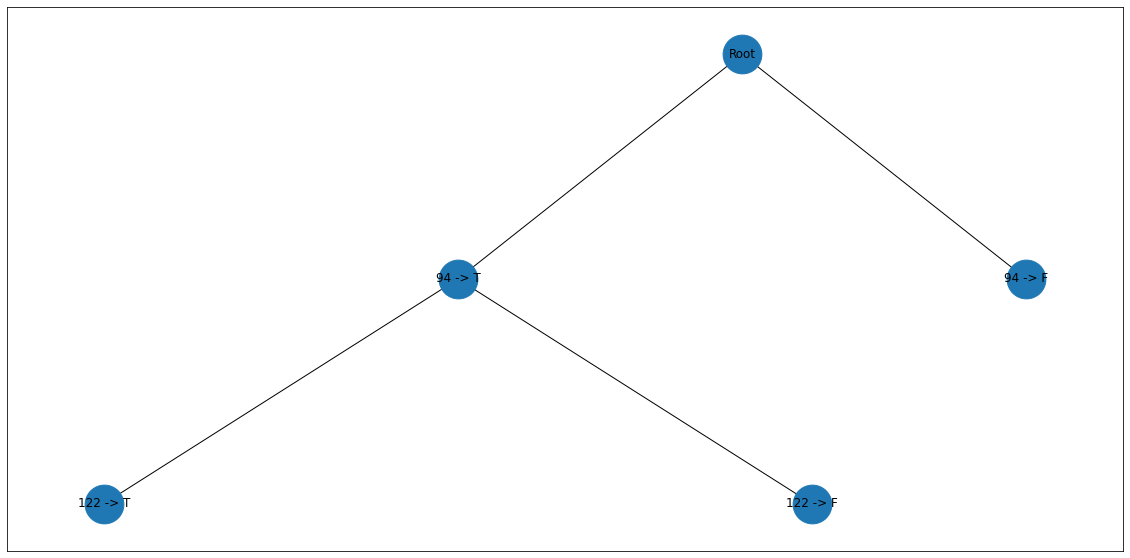

alt.HConcatChart(...)

In [10]:
tangles.contracted_tangles_tree_.plot_tree()
p.assignments(data.xs, ys_tangles).properties(width=300, height=240) | p.assignments(data.xs, ys_kmeans).properties(width=300, height=240)

In [ ]:
def plot_cut_contracted(cuts, col): 
    return p.assignments(data.xs, cuts[:, col]).properties(title=f"cut {col}")
cuts = tangles.cuts_.values.T
# for col in [94, 126, 101, 96]:
#     plot_cut_contracted(tangles.cuts_.values.T, col).display()
for col in [94, 122]:
     plot_cut_contracted(tangles.cuts_.values.T, col).display()

alt.Chart(...)

alt.Chart(...)

## Observations about cut behaviour
We have remarked above that the performance is a lot better when the "uninformative" part of a cut (e.g. we ask whether a dog is closer to cat A or cat B) is not randomly noisy, but consistent. This can be shown pretty easily:

# triplets used: 10800
NMI tangles: 1.0 (4)
NMI soe-kmeans: 0.7658484758542152


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

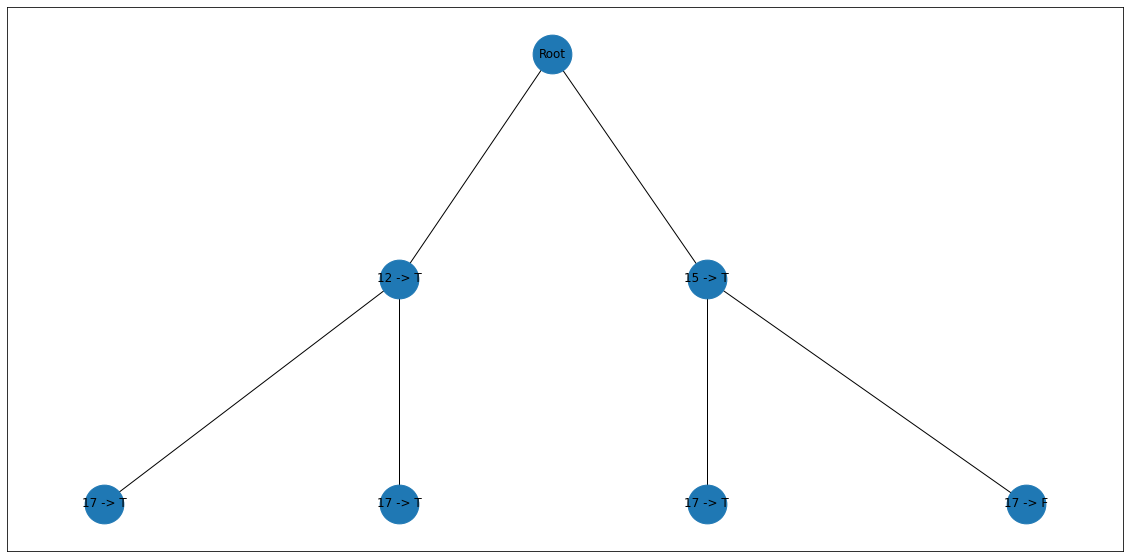

In [ ]:
q = Questionnaire.from_hierarchy(tree, data.ys, density=0.0001, seed=seed, verbose=False, randomize_ties=False, imputation_method="random")
print(f"# triplets used: {q.values.size}")
tangles = OrdinalTangles(agreement=90, verbose=False)
ys_tangles = tangles.fit_predict(q.values)
print(f"NMI tangles: {normalized_mutual_info_score(ys_tangles, data.ys)} ({np.unique(ys_tangles).size})")

soe_kmeans = SoeKmeans(embedding_dimension=2, n_clusters=4, seed=seed)
ys_kmeans = soe_kmeans.fit_predict(*q.to_bool_array())
print(f"NMI soe-kmeans: {normalized_mutual_info_score(ys_kmeans, data.ys)}")
cuts = tangles.cuts_.values.T
plot_cut_contracted(cuts, 12).display()
plot_cut_contracted(cuts, 15).display()
plot_cut_contracted(cuts, 17).display()
tangles.contracted_tangles_tree_.plot_tree()

More info can be read in experiment 19.